In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(x)
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [4]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers)
        self.conv1 = nn.Conv1d(20, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv1d(64, 20, kernel_size=3, stride=1, padding=1, bias=False)
        self.linear = nn.Linear(hidden_size * 3, hidden_size * 2)

        self.attention = SELayer(64,16)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, encoder_states, hidden, cell):

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        attention_input = torch.cat((h_reshaped, encoder_states), dim=2)
        attention_input = attention_input.transpose(0,1)
        attention_input = self.conv1(attention_input)
        context_vector = self.attention(attention_input)
        context_vector = self.conv2(context_vector)
        context_vector = self.linear(context_vector)
        context_vector = context_vector.transpose(0,1)

        rnn_input = context_vector
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(20*22, 1)

    def forward(self, source, teacher_force_ratio=0.5):
        source = source.transpose(0,1)
        batch_size = source.shape[1]
        target_len = source.shape[0]
        target_vocab_size = 22

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # At every time step use encoder_states and update hidden, cell
        output, hidden, cell = self.decoder(encoder_states, hidden, cell)

        # Store prediction for current time step
        outputs = output
            
        outputs = outputs.transpose(0,1)
        outputs = self.flatten(outputs)
        outputs = self.final_layer(outputs)

        return outputs

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_net = Encoder(
    input_size=22,  
    hidden_size=32, 
    num_layers=1, 
    p=0
).to(device)

decoder_net = Decoder(
    input_size=22,
    hidden_size=32,
    output_size=22,
    num_layers=1,
    p=0,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [7]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x,x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[0.0477],
        [0.0479],
        [0.0382],
        [0.0427],
        [0.0408]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [10]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [11]:
df_for_training=df[feature_names].astype(float)

In [12]:
df_for_training.shape

(11524, 22)

In [13]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [14]:
trainX=[]
trainY=[]

In [15]:
n_future=1
n_past=20

In [16]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [17]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [18]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [19]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [20]:
data,label=random_shuffle(trainX,trainY)

In [21]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [23]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.06003399193286896
Epoch: 1 Loss: 0.12841327488422394
Epoch: 2 Loss: 0.052167221903800964
Epoch: 3 Loss: 0.023205799981951714
Epoch: 4 Loss: 0.05431076139211655
Epoch: 5 Loss: 0.12401431798934937
Epoch: 6 Loss: 0.1509910523891449
Epoch: 7 Loss: 0.06544047594070435
Epoch: 8 Loss: 0.05015811324119568
Epoch: 9 Loss: 0.07416984438896179
Epoch: 10 Loss: 0.01746893674135208
Epoch: 11 Loss: 0.03228949010372162
Epoch: 12 Loss: 0.020704472437500954
Epoch: 13 Loss: 0.025191770866513252
Epoch: 14 Loss: 0.03745786473155022
Epoch: 15 Loss: 0.05147871375083923
Epoch: 16 Loss: 0.03759337216615677
Epoch: 17 Loss: 0.07267727702856064
Epoch: 18 Loss: 0.04028366878628731
Epoch: 19 Loss: 0.05562427639961243
Epoch: 20 Loss: 0.07400870323181152
Epoch: 21 Loss: 0.035786982625722885
Epoch: 22 Loss: 0.033601488918066025
Epoch: 23 Loss: 0.03121194988489151
Epoch: 24 Loss: 0.021589091047644615
Epoch: 25 Loss: 0.04335763305425644
Epoch: 26 Loss: 0.07189413905143738
Epoch: 27 Loss: 0.02763338200747

Epoch: 222 Loss: 0.01647232286632061
Epoch: 223 Loss: 0.012928180396556854
Epoch: 224 Loss: 0.01827029325067997
Epoch: 225 Loss: 0.01867292821407318
Epoch: 226 Loss: 0.017974520102143288
Epoch: 227 Loss: 0.015103768557310104
Epoch: 228 Loss: 0.005169002339243889
Epoch: 229 Loss: 0.02230263128876686
Epoch: 230 Loss: 0.010356996208429337
Epoch: 231 Loss: 0.0306268110871315
Epoch: 232 Loss: 0.016682762652635574
Epoch: 233 Loss: 0.02417801134288311
Epoch: 234 Loss: 0.015622889623045921
Epoch: 235 Loss: 0.023959672078490257
Epoch: 236 Loss: 0.008843324147164822
Epoch: 237 Loss: 0.006765108555555344
Epoch: 238 Loss: 0.007206061389297247
Epoch: 239 Loss: 0.01732807233929634
Epoch: 240 Loss: 0.012302787974476814
Epoch: 241 Loss: 0.010332074947655201
Epoch: 242 Loss: 0.010561924427747726
Epoch: 243 Loss: 0.00797282624989748
Epoch: 244 Loss: 0.011919615790247917
Epoch: 245 Loss: 0.022307466715574265
Epoch: 246 Loss: 0.007499589119106531
Epoch: 247 Loss: 0.017870737239718437
Epoch: 248 Loss: 0.00

Epoch: 439 Loss: 0.015419581905007362
Epoch: 440 Loss: 0.008548972196877003
Epoch: 441 Loss: 0.006242891773581505
Epoch: 442 Loss: 0.0308388639241457
Epoch: 443 Loss: 0.026563068851828575
Epoch: 444 Loss: 0.007914768531918526
Epoch: 445 Loss: 0.012037507258355618
Epoch: 446 Loss: 0.020075250416994095
Epoch: 447 Loss: 0.020413562655448914
Epoch: 448 Loss: 0.0058245789259672165
Epoch: 449 Loss: 0.025580991059541702
Epoch: 450 Loss: 0.01383211836218834
Epoch: 451 Loss: 0.007072392851114273
Epoch: 452 Loss: 0.014627773314714432
Epoch: 453 Loss: 0.024375198408961296
Epoch: 454 Loss: 0.006525574252009392
Epoch: 455 Loss: 0.007063638418912888
Epoch: 456 Loss: 0.015376431867480278
Epoch: 457 Loss: 0.005305287428200245
Epoch: 458 Loss: 0.009688725695014
Epoch: 459 Loss: 0.009898468852043152
Epoch: 460 Loss: 0.02155829593539238
Epoch: 461 Loss: 0.023383062332868576
Epoch: 462 Loss: 0.02477378584444523
Epoch: 463 Loss: 0.007913680747151375
Epoch: 464 Loss: 0.026533545926213264
Epoch: 465 Loss: 0.

Epoch: 656 Loss: 0.007069151848554611
Epoch: 657 Loss: 0.007570822723209858
Epoch: 658 Loss: 0.013827456161379814
Epoch: 659 Loss: 0.007644038647413254
Epoch: 660 Loss: 0.013379054144024849
Epoch: 661 Loss: 0.02404121495783329
Epoch: 662 Loss: 0.006772724445909262
Epoch: 663 Loss: 0.01943913660943508
Epoch: 664 Loss: 0.014752065762877464
Epoch: 665 Loss: 0.006260729394853115
Epoch: 666 Loss: 0.008838891051709652
Epoch: 667 Loss: 0.004535070154815912
Epoch: 668 Loss: 0.027318287640810013
Epoch: 669 Loss: 0.01352686621248722
Epoch: 670 Loss: 0.0042014834471046925
Epoch: 671 Loss: 0.01074768416583538
Epoch: 672 Loss: 0.003080635331571102
Epoch: 673 Loss: 0.011325221508741379
Epoch: 674 Loss: 0.014459783211350441
Epoch: 675 Loss: 0.008097527548670769
Epoch: 676 Loss: 0.0074239857494831085
Epoch: 677 Loss: 0.005253336392343044
Epoch: 678 Loss: 0.013259430415928364
Epoch: 679 Loss: 0.004910547286272049
Epoch: 680 Loss: 0.010191963985562325
Epoch: 681 Loss: 0.009359102696180344
Epoch: 682 Los

Epoch: 873 Loss: 0.022248215973377228
Epoch: 874 Loss: 0.009241614490747452
Epoch: 875 Loss: 0.013519994914531708
Epoch: 876 Loss: 0.006297718733549118
Epoch: 877 Loss: 0.010609189048409462
Epoch: 878 Loss: 0.006461434066295624
Epoch: 879 Loss: 0.010812433436512947
Epoch: 880 Loss: 0.020939484238624573
Epoch: 881 Loss: 0.007896305993199348
Epoch: 882 Loss: 0.022818250581622124
Epoch: 883 Loss: 0.022246912121772766
Epoch: 884 Loss: 0.011548305861651897
Epoch: 885 Loss: 0.011475401930510998
Epoch: 886 Loss: 0.012448931112885475
Epoch: 887 Loss: 0.013546006754040718
Epoch: 888 Loss: 0.005141970701515675
Epoch: 889 Loss: 0.01576552540063858
Epoch: 890 Loss: 0.003621491836383939
Epoch: 891 Loss: 0.00732069369405508
Epoch: 892 Loss: 0.014229647815227509
Epoch: 893 Loss: 0.009922943077981472
Epoch: 894 Loss: 0.0023265122435986996
Epoch: 895 Loss: 0.013826987706124783
Epoch: 896 Loss: 0.018744248896837234
Epoch: 897 Loss: 0.009084781631827354
Epoch: 898 Loss: 0.004015335347503424
Epoch: 899 Lo

In [24]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [25]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [26]:
predictions = np.array(predictions)

In [27]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [28]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

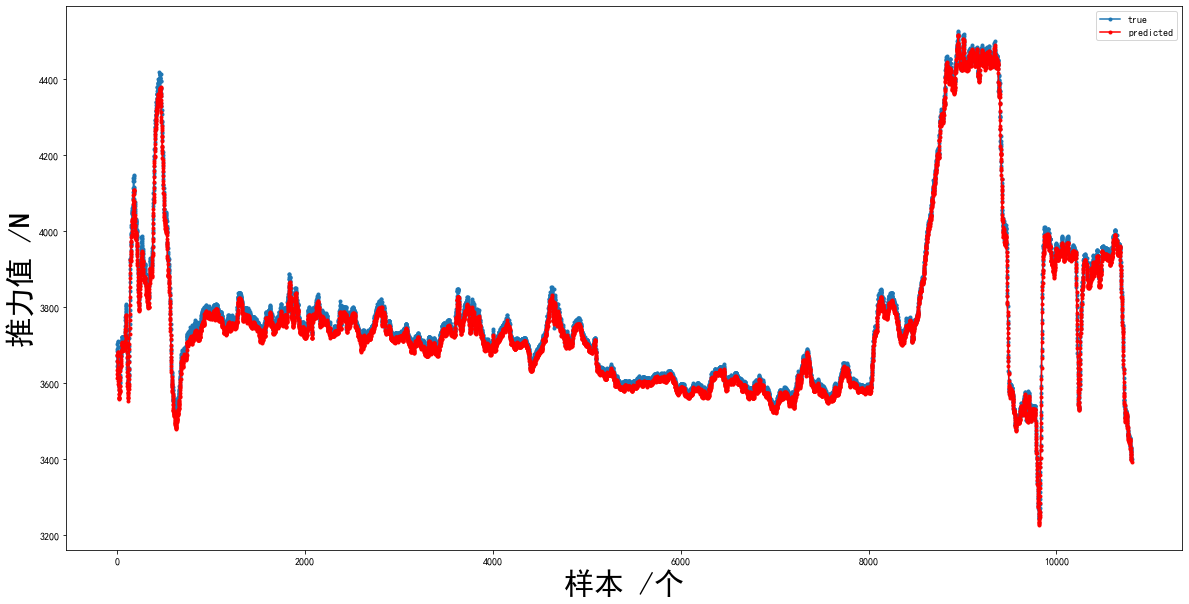

In [29]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();